# Setup

In [1]:
import os
if os.getcwd().endswith("notebooks"):
    os.chdir("..")
print(os.getcwd())


/Users/davidbellenberg/github_projects/Loan-Risk-Optimizer


In [2]:
#install requirements.txt
#!pip install -r requirements.txt


In [3]:
from utils.data_loader import load_data
import yaml
from utils.helpers import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator
from typing import Tuple, Optional
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import EarlyStopping
from termcolor import colored
from tqdm import tqdm
from catboost import CatBoostClassifier
from IPython.display import clear_output


In [4]:
# load config file
config = load_config()
config

{'dataset': {'name': 'Loan-Risk-Optimizer',
  'data_path': 'data/heloc.csv',
  'feature_descriptions': {'RiskPerformance': 'Paid as negotiated flag (12-36 months). String of Good and Bad',
   'ExternalRiskEstimate': 'Consolidated version of risk markers',
   'MSinceOldestTradeOpen': 'Months Since Oldest Trade Open',
   'MSinceMostRecentTradeOpen': 'Months Since Most Recent Trade Open',
   'AverageMInFile': 'Average Months in File',
   'NumSatisfactoryTrades': 'Number of credit agreements with on-time payments',
   'NumTrades60Ever2DerogPubRec': 'Number of trade lines 60 days past due date, includes derogatory public records',
   'NumTrades90Ever2DerogPubRec': 'Number of trade lines 90 days past due date, includes derogatory public records',
   'NumTotalTrades': 'Total number of credit accounts',
   'NumTradesOpeninLast12M': 'Number of Trades Open in Last 12 Months',
   'PercentTradesNeverDelq': 'Percent Trades Never Delinquent',
   'MSinceMostRecentDelq': 'Months Since Most Recent Deli

In [5]:
#get feature info for NumInqLast6Mexcl7days
config["dataset"]['feature_descriptions']['NumInqLast6Mexcl7days']

'Number of Inquiries in Last 6 Months excluding 7 days'

# Data Exploration and Preprocessing

In [6]:
file_path = config["dataset"]["data_path"]

# Load the dataset
df = pd.read_csv(file_path)

print("Datset shape: ", df.shape)

Datset shape:  (10459, 24)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   RiskPerformance                     10459 non-null  object
 1   ExternalRiskEstimate                10459 non-null  int64 
 2   MSinceOldestTradeOpen               10459 non-null  int64 
 3   MSinceMostRecentTradeOpen           10459 non-null  int64 
 4   AverageMInFile                      10459 non-null  int64 
 5   NumSatisfactoryTrades               10459 non-null  int64 
 6   NumTrades60Ever2DerogPubRec         10459 non-null  int64 
 7   NumTrades90Ever2DerogPubRec         10459 non-null  int64 
 8   PercentTradesNeverDelq              10459 non-null  int64 
 9   MSinceMostRecentDelq                10459 non-null  int64 
 10  MaxDelq2PublicRecLast12M            10459 non-null  int64 
 11  MaxDelqEver                         10459 non-null  in

### Handelling Special Values

- -9: No Bureau Record or No Investigation
- -8: No Usable/Valid Trades or Inquiries
- -7: Condition not Met (e.g., No Inquiries, No Delinquencies)

In [8]:
# Remove rows where *all* features (excluding the first column) are -7, -8, or -9
df = df.loc[~df.iloc[:, 1:].isin([-7, -8, -9]).all(axis=1)]

print("Datset shape: ", df.shape)

Datset shape:  (9871, 24)


In [9]:
# label encoding target variable, Bad -> 9, Good -> 1
le = LabelEncoder()
df["RiskPerformance"] = le.fit_transform(df['RiskPerformance'])

### Removing Outliers

In [10]:
Q1 = df.quantile(0) # because we want to include special values like -7, -8, -9
Q3 = df.quantile(0.9)
IQR = Q3 - Q1

# Columns to exclude from outlier filtering
excluded_columns = ['RiskPerformance', 'MaxDelq2PublicRecLast12M', 'MaxDelqEver']

# Create a mask for outliers, excluding the specified columns
outlier_mask = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))) & ~df.isin(excluded_columns)

#print how many rows have outliers 
print("Number of rows with outliers: ", outlier_mask.any(axis=1).sum())

# Filter out the outliers except for the excluded columns
df_filtered = df[~(outlier_mask).any(axis=1)]

print("Shape of filtered data: ", df_filtered.shape)


Number of rows with outliers:  536
Shape of filtered data:  (9335, 24)


In [11]:
#scale the data excpet first column
scaler = StandardScaler()

#make a copy of the dataframe
df_filtered_scaled = df_filtered.copy()

df_filtered_scaled.iloc[:, 1:] = scaler.fit_transform(df_filtered.iloc[:, 1:])




### Visualizing each feature

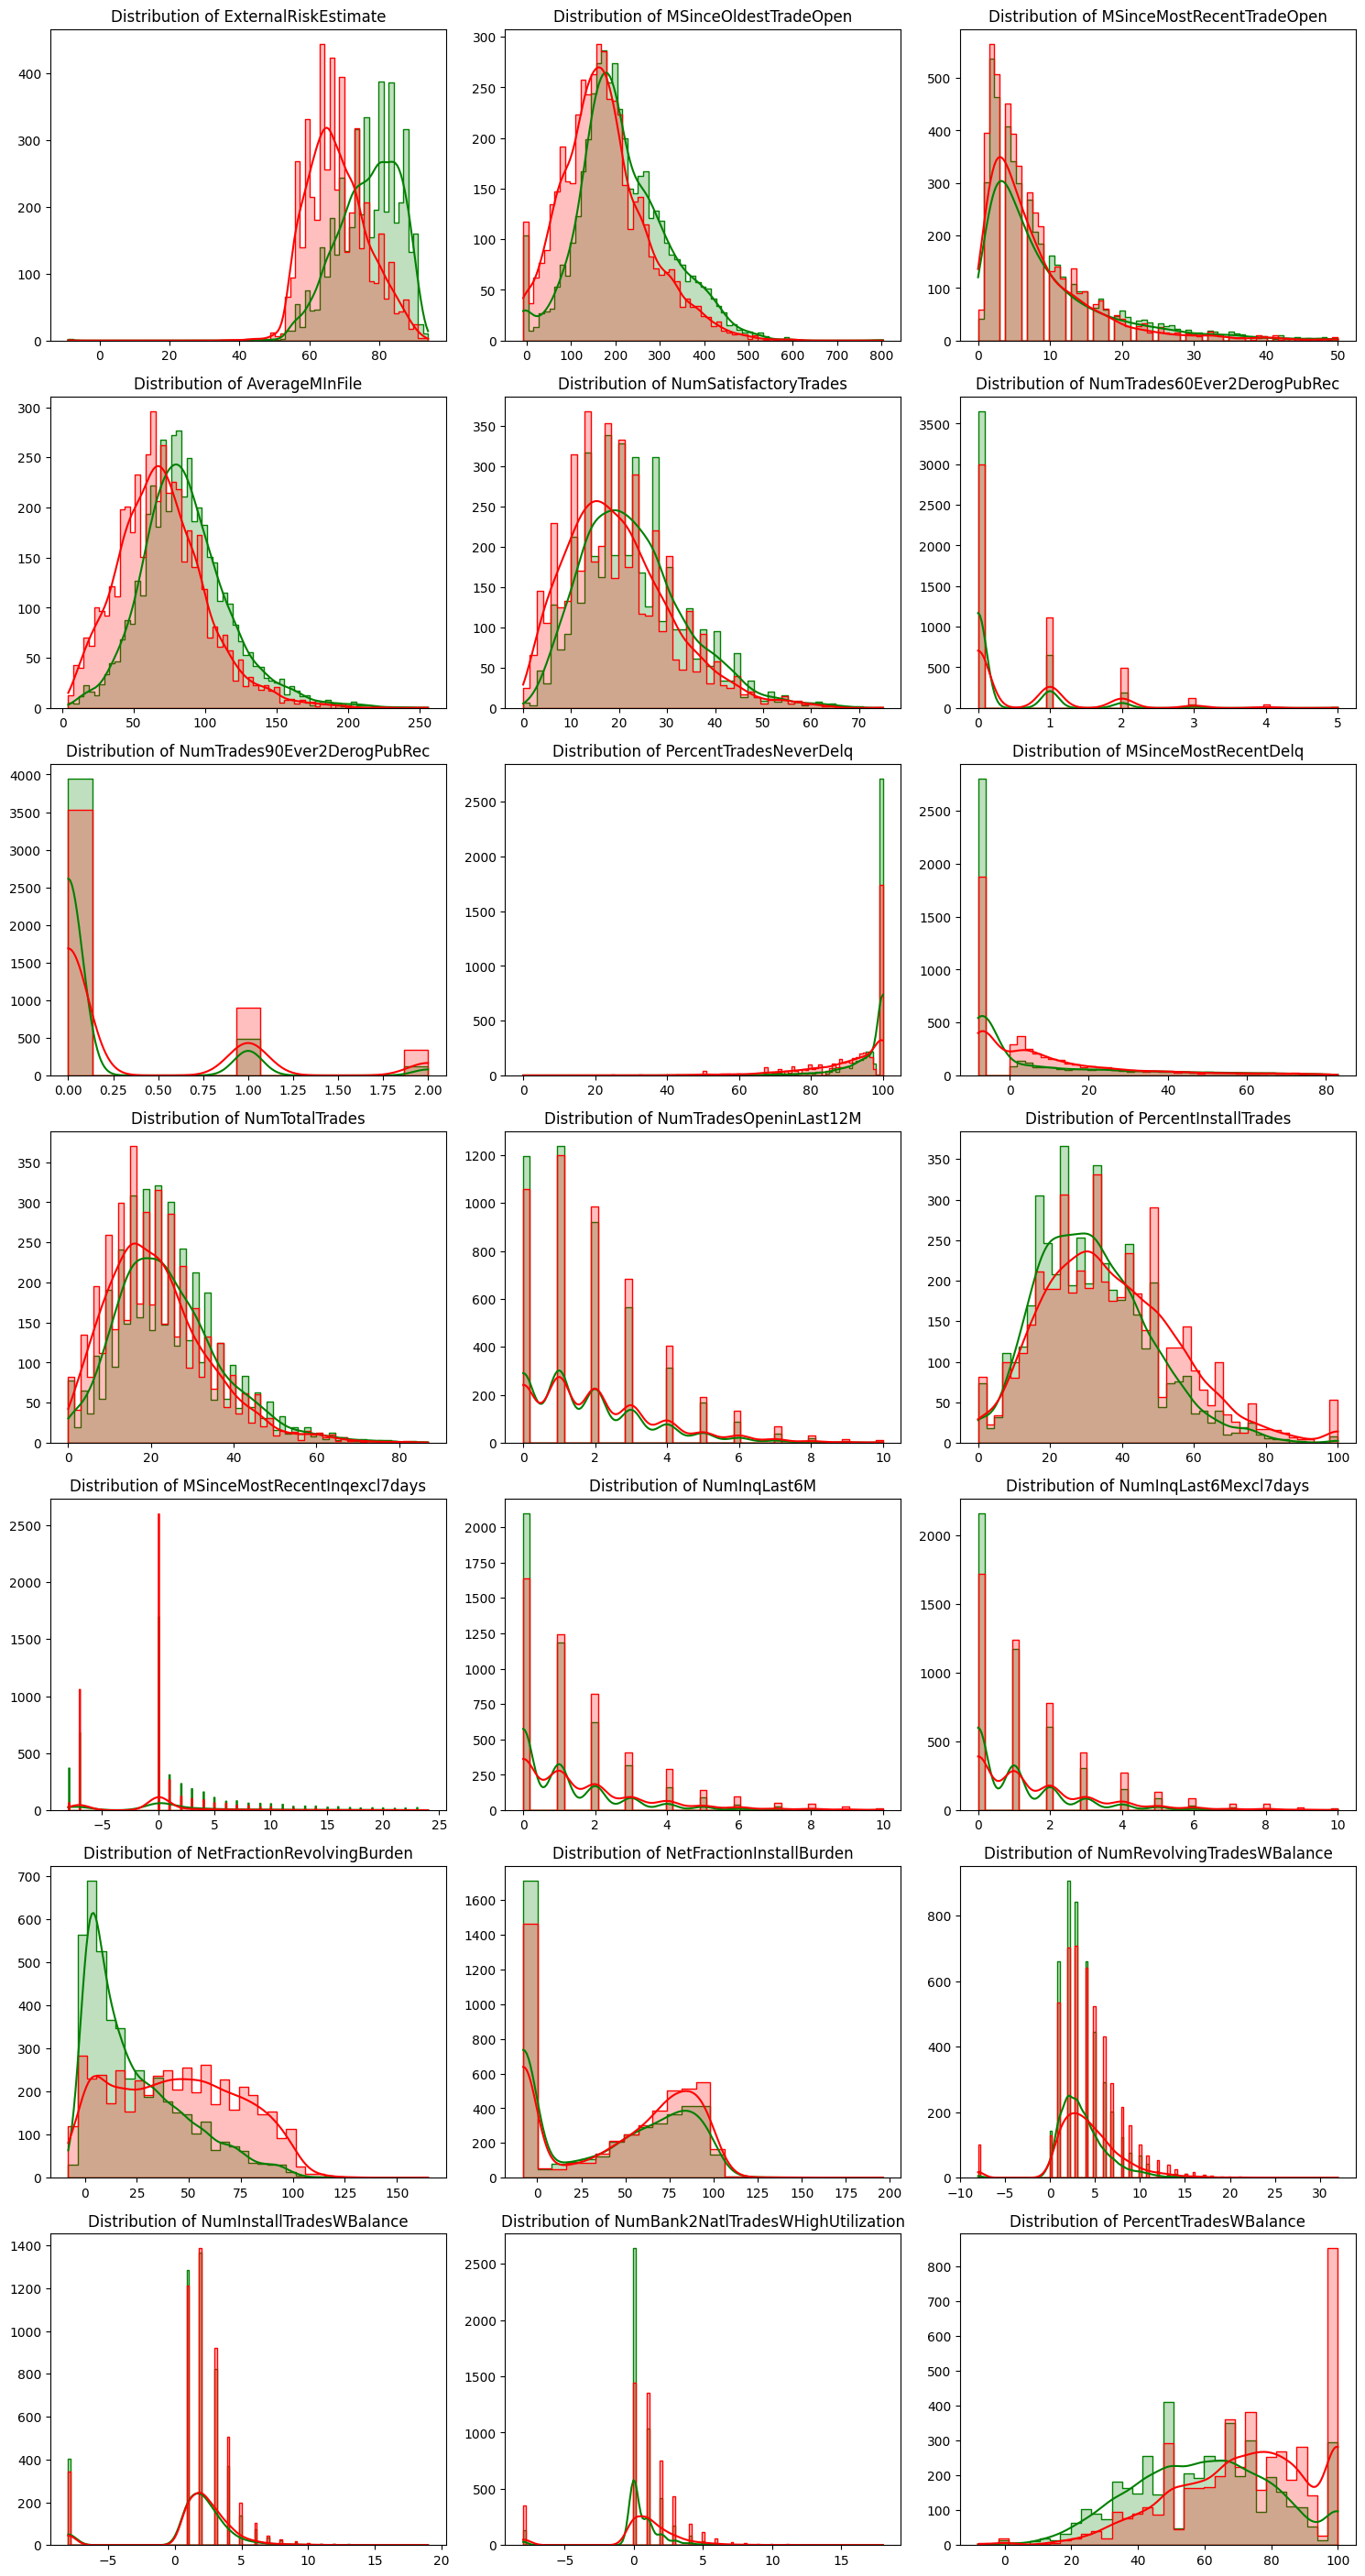

In [12]:
# Number of rows and columns for the subplot grid
n_cols = 3
n_rows = (len(df.columns) + n_cols - 1) // n_cols  # This ensures enough rows to accommodate all plots

plt.figure(figsize=(15, 4 * n_rows))  # Adjust the figure size as needed

# Loop through each column, except for 'RiskPerformance' 'MaxDelq2PublicRecLast12M', 'MaxDelqEver'
for i, column in enumerate(df_filtered_scaled.drop(excluded_columns, axis=1).columns):
    plt.subplot(n_rows, n_cols, i + 1)  # Create a subplot for each column, no axis labels
    sns.histplot(data=df_filtered, x=column, hue='RiskPerformance', kde=True, element='step', palette=['red', 'green'],legend=False)
    
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()


## Split Data, Train Classifiers

In [13]:
# Separate features and target
y = df_filtered_scaled.loc[:,'RiskPerformance']
X = df_filtered_scaled.drop(['RiskPerformance'], axis = 1)

val_size = 0.2
test_size = 0.5

# Calculate validation size with respect to the original dataset
val_size_adjusted = val_size / (1 - test_size)

# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=42)

#split the validation set into validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=test_size, random_state=42)

#print the shape of the train, validation and test sets
print("Shape of train set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of train set:  (7468, 23)
Shape of validation set:  (933, 23)
Shape of test set:  (934, 23)


### Training Models

## Training & Tuning Models

#### Helper functions

In [14]:
def train_model(model: BaseEstimator,  class_weights: Optional[dict] = None):

    print("Training", colored(model.__class__.__name__, "blue"), end=" ")

    # Set class weights if provided
    if class_weights:
        if hasattr(model, 'class_weight'):
            model.set_params(class_weight=class_weights)

    with tqdm(total=100, desc="Training Progress",) as pbar:
        #if model a neural network
        if hasattr(model, 'model'):
            model.fit(X_train, y_train, validation_data=(X_val, y_val),verbose=1)
        else:
            # Train the model
                model.fit(X_train, y_train)   
        pbar.update(100)  
    print()
    
    return model

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

def optimize_model_params(model, param_grid, X_train, y_train, n_iter=150, cv=3, verbose=0, random_state=42, parallel_processing=True):
    """
    Optimize model parameters using RandomizedSearchCV.

    :param model: The machine learning model
    :param param_grid: Dictionary of parameters to be optimized
    :param X_train: Training data features
    :param y_train: Training data labels
    :param n_iter: Number of parameter settings sampled (default 100)
    :param cv: Number of folds in cross-validation (default 3)
    :param verbose: Verbosity level (default 2)
    :param random_state: Seed for random number generator (default 42)
    :param parallel_processing: Use all CPU cores if True (default True)
    :return: Tuple of (model fitted with the best parameters, best parameters found)
    """
    
    n_jobs = -1 if parallel_processing else 1
    print(colored(model.__class__.__name__, "blue"))

    print(" - Optimizing Parameters", end=" ")

    try:
        optimizer = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=cv, verbose=verbose, random_state=random_state, n_jobs=n_jobs)
    
        print(colored("done", "green"))
        print(" - Training", end=" ")

        #train the model
        optimizer.fit(X_train, y_train)

        print(colored("done", "green"))
        print()
        print("Best parameters:", optimizer.best_params_)
        print()

        return optimizer.best_estimator_, optimizer.best_params_
        
    except Exception as e:
        print(f"An error occurred during model optimization: {e}")
        return None, None


### Neural Network

In [16]:
def create_nn():
    model = Sequential()
    model.add(Dense(160, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=0.01),  # Lower learning rate
                loss='binary_crossentropy', 
                metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')


In [17]:
nn_model = train_model(KerasClassifier(model=create_nn, epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping]))


Training KerasClassifier 

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

2023-12-17 01:05:04.703509: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-17 01:05:04.703555: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-17 01:05:04.703565: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-17 01:05:04.703606: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-17 01:05:04.703625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-12-17 01:05:05.063651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - 2s 11ms/step - loss: 0.6610 - accuracy: 0.6494 - val_loss: 0.5792 - val_accuracy: 0.7031
Epoch 2/100
117/117 [==============================] - 1s 9ms/step - loss: 0.6084 - accuracy: 0.6913 - val_loss: 0.5731 - val_accuracy: 0.7203
Epoch 3/100
117/117 [==============================] - 1s 9ms/step - loss: 0.5915 - accuracy: 0.6975 - val_loss: 0.5713 - val_accuracy: 0.7235
Epoch 4/100
117/117 [==============================] - 1s 9ms/step - loss: 0.5853 - accuracy: 0.7055 - val_loss: 0.5687 - val_accuracy: 0.7245
Epoch 5/100
117/117 [==============================] - 1s 8ms/step - loss: 0.5810 - accuracy: 0.7033 - val_loss: 0.5674 - val_accuracy: 0.7310
Epoch 6/100
117/117 [==============================] - 1s 9ms/step - loss: 0.5765 - accuracy: 0.7110 - val_loss: 0.5683 - val_accuracy: 0.7181
Epoch 7/100
117/117 [==============================] - 1s 9ms/step - loss: 0.5832 - accuracy: 0.7042 - val_loss: 0.5668 - val_accuracy: 0.7224
Epoch 8/10

Training Progress: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]

#### Random Search best Params for LR, RF, XGB, CATBoost

In [18]:
optimized_lr_model, lr_best_params = optimize_model_params(
    LogisticRegression(), 
    config["models"]["logistic_regression"], 
    X_train, 
    y_train
)

optimized_rf_model, rf_best_params = optimize_model_params(
    RandomForestClassifier(), 
    config["models"]["random_forest"], 
    X_train, 
    y_train
)

#optimized xgboost model
optimized_xgb_model, xgb_best_params = optimize_model_params(
    XGBClassifier(), 
    config["models"]["xgboost"], 
    X_train, 
    y_train
)

#optimized catboost model
optimized_catboost_model, catboost_best_params = optimize_model_params(
    CatBoostClassifier(verbose=False), 
    config["models"]["catboost"], 
    X_train, 
    y_train
)

LogisticRegression
 - Optimizing Parameters done
 - Training done

Best parameters: {'solver': 'liblinear', 'max_iter': 100, 'C': 0.01}

RandomForestClassifier
 - Optimizing Parameters done
 - Training 

/Users/davidbellenberg/github_projects/Loan-Risk-Optimizer/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


done

Best parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}

XGBClassifier
 - Optimizing Parameters done
 - Training 

/Users/davidbellenberg/github_projects/Loan-Risk-Optimizer/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 96 is smaller than n_iter=150. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


done

Best parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}

CatBoostClassifier
 - Optimizing Parameters done
 - Training 

/Users/davidbellenberg/github_projects/Loan-Risk-Optimizer/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 96 is smaller than n_iter=150. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


done

Best parameters: {'learning_rate': 0.01, 'iterations': 1000, 'depth': 8}



In [19]:
#optimized model list
optimized_models = [optimized_lr_model, optimized_rf_model, optimized_xgb_model, optimized_catboost_model, nn_model]


## Evaluate Models on validation set

In [20]:
#evaluate all optimized models on validation set
for model in optimized_models:
    evaluate(X_val, y_val, model)

LogisticRegression
 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       490
           1       0.71      0.72      0.72       443

    accuracy                           0.73       933
   macro avg       0.73      0.73      0.73       933
weighted avg       0.73      0.73      0.73       933

 Accuracy: 0.73

 Confusion Matrix:
[[358 132]
 [122 321]]



RandomForestClassifier
 Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       490
           1       0.70      0.72      0.71       443

    accuracy                           0.72       933
   macro avg       0.72      0.72      0.72       933
weighted avg       0.72      0.72      0.72       933

 Accuracy: 0.72

 Confusion Matrix:
[[353 137]
 [125 318]]

XGBClassifier
 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       490
           1       0.71      0.73      0.72       443

    accuracy                           0.73       933
   macro avg       0.73      0.73      0.73       933
weighted avg       0.73      0.73      0.73       933

 Accuracy: 0.73

 Confusion Matrix:
[[358 132]
 [119 324]]

CatBoostClassifier
 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.7

15/15 [==============================] - 0s 2ms/step


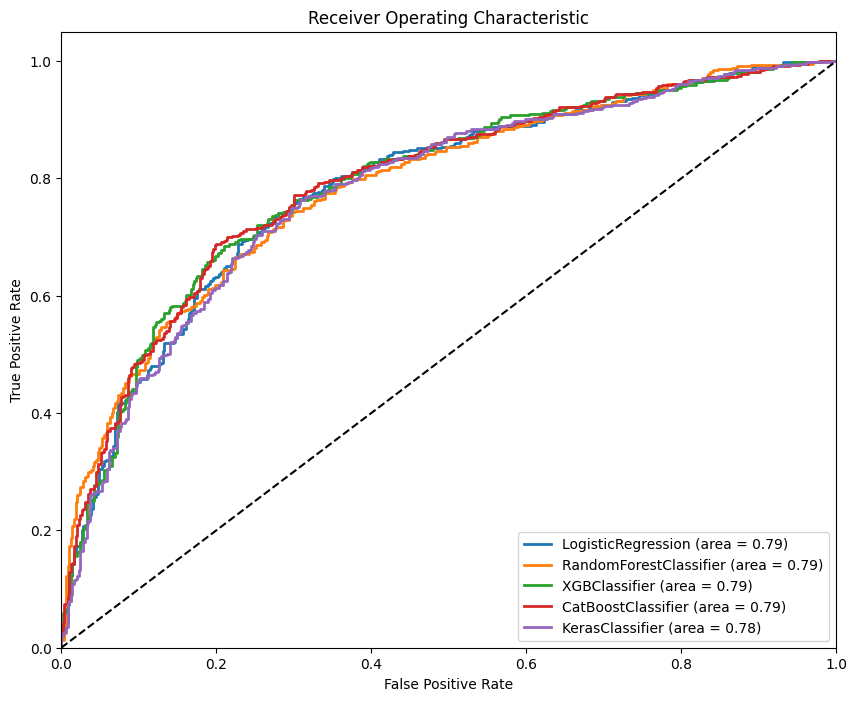

In [21]:
def plot_roc_curves(models, X_val, y_val):

    plt.figure(figsize=(10, 8))

    #iterate through each model and plot roc curve
    for model in models:
        # Get model predictions as probabilities
        #if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_val)[:, 1]

        # Compute ROC curve and ROC area for each model
        fpr, tpr, _ = roc_curve(y_val, y_scores)
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, linewidth=2, label=f'{model.__class__.__name__} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


# Plot ROC curves
plot_roc_curves(optimized_models, X_val, y_val)

## Cost sensitvity/ threshold optimization

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

# Function to apply threshold to predicted probabilities and return binary predictions
def apply_threshold(probabilities, threshold=0.5):
    return (probabilities >= threshold).astype(int)

# Function to get predictions from a model using a threshold
def get_model_predictions(model, X, threshold=0.5, is_neural_network=False):
    if is_neural_network:
        # Neural network uses the `predict` method directly to get probabilities
        probabilities = model.predict(X).flatten()
    else:
        # Other models use `predict_proba` and we are interested in the probabilities of class 1
        probabilities = model.predict_proba(X)[:, 1]
    
    return apply_threshold(probabilities, threshold)


In [23]:
from sklearn.metrics import confusion_matrix

# Function to calculate the cost ratio
def cost_ratio(conf_matrix):
    # Extracting true positives (TP) and false positives (FP) from the confusion matrix
    TP = conf_matrix[1, 1]
    FP = conf_matrix[0, 1]
    # Calculate the ratio of true positives to false positives
    # We add a small value to the denominator to avoid division by zero
    ratio = TP / (FP + 1e-10)
    return ratio

# Function to perform grid search for the best threshold for a given model on validation set
def find_best_threshold(model, X_valid, y_valid, thresholds, is_neural_network=False):
    best_threshold = 0
    best_ratio = 0
    for threshold in thresholds:
        predictions = get_model_predictions(model, X_valid, threshold, is_neural_network)
        conf_matrix = confusion_matrix(y_valid, predictions)
        ratio = cost_ratio(conf_matrix)
        
        if ratio > best_ratio:
            best_ratio = ratio
            best_threshold = threshold
            
    return best_threshold, best_ratio

In [24]:
# Threshold values to explore
thresholds = np.linspace(0.5, 0.9, 50)

# Find the best threshold for each model
threshold_results = {}
for i, model in enumerate(optimized_models):
    is_neural_network = (i == 4) # Assuming the neural network is at index 3 in the models list
    best_threshold, best_ratio = find_best_threshold(model, X_val, y_val, thresholds, is_neural_network)
    threshold_results[i] = best_threshold
    print(f'Model: {model.__class__.__name__}')
    print(f'Best Threshold: {threshold_results[i]:.4f}')
    print()


print(threshold_results)

Model: LogisticRegression
Best Threshold: 0.8755

Model: RandomForestClassifier
Best Threshold: 0.9000

Model: XGBClassifier
Best Threshold: 0.9000

Model: CatBoostClassifier
Best Threshold: 0.8918

15/15 [==============================] - 0s 2ms/step
Model: KerasClassifier
Best Threshold: 0.5000

{0: 0.8755102040816327, 1: 0.9, 2: 0.9, 3: 0.8918367346938776, 4: 0.5}


## Ensemble majority voting

In [26]:
from scipy.stats import mode

# Adjust the get_adjusted_predictions function to use model names
def get_adjusted_predictions(models, threshold_results, X):
    adjusted_predictions = []

    for i, model in enumerate(models):
        is_neural_network = (i == 4)  # Assuming the neural network is at index 3 in the models list
        best_threshold = threshold_results[i]
        predictions = get_model_predictions(model, X, best_threshold, is_neural_network)
        adjusted_predictions.append(predictions)
    return adjusted_predictions

# Function to perform majority voting
def majority_voting(adjusted_predictions):
    # Combine predictions from all models (axis=0)
    combined_predictions = np.vstack(adjusted_predictions)
    # Perform majority vote using mode along the column axis (axis=0)
    final_predictions, _ = mode(combined_predictions, axis=0)
    return final_predictions.ravel()  # Flatten the array to 1D


### majority voting on validation set

In [27]:
# Now, use the updated function with model names
adjusted_predictions = get_adjusted_predictions(optimized_models, threshold_results, X_val)

# Proceed with majority voting and evaluation
ensemble_final_predictions = majority_voting(adjusted_predictions)
ensemble_final_conf_matrix = confusion_matrix(y_val, ensemble_final_predictions)

print('Ensemble Final Confusion Matrix:')
print(ensemble_final_conf_matrix)

15/15 [==============================] - 0s 2ms/step
Ensemble Final Confusion Matrix:
[[485   5]
 [390  53]]


### majority voting on test set

In [28]:
# Now, use the updated function with model names
adjusted_predictions = get_adjusted_predictions(optimized_models, threshold_results, X_test)

# Proceed with majority voting and evaluation
ensemble_final_predictions = majority_voting(adjusted_predictions)
ensemble_final_conf_matrix = confusion_matrix(y_test, ensemble_final_predictions)

print('Ensemble Final Confusion Matrix:')
print(ensemble_final_conf_matrix)

15/15 [==============================] - 0s 3ms/step
Ensemble Final Confusion Matrix:
[[490   4]
 [387  53]]
